```{note}
If running in Colab, think of changing the runtime type before starting, in
order  to have access to GPU ressources: Runtime->Change Runtime Type, then
chose GPU for hardware accelerator.
```


# 0. Classification of Alzheimer's disease diagnosis

The goal of this lab session is to train a network that will perform a binary
classification between control participants and patients that are affected by
Alzheimer's disease. The input of the network is a neuroimaging modality: the
T1 weighted MRI. In this project we use the [Pytorch
library](https://pytorch.org/).

In [1]:
import torch
import numpy as np
import pandas as pd
from torch import nn
from time import time
from os import path
from torchvision import transforms
import random
from copy import deepcopy
import urllib.request
import ssl
import tarfile

## Database

In this session we use the images from a public research project:
[OASIS-1](https://www.oasis-brains.org/#data).
Two labels exist in this dataset:
- CN (Cognitively Normal) for healthy participants.
- AD (Alzheimer's Disease) for patients affected by Alzheimer's disease.

The original images were preprocessed using [Clinica](http://www.clinica.run/): 
a software platform for clinical neuroimaging studies. 
Preprocessed images and other files are distributed in a tarball, run 
the following command to download it.

In [2]:
gcontext = ssl.SSLContext()
dataseturl = "https://aramislab.paris.inria.fr/files/data/databases/DL4MI/OASIS-1-dataset_pt_new.tar.gz" 
fstream = urllib.request.urlopen(dataseturl, context=gcontext)
tarfile = tarfile.open(fileobj=fstream, mode="r:gz")
tarfile.extractall()

One crucial step before training a neural network is to check the dataset.
Are the classes balanced? Are there biases in the dataset that may
differentiate the labels?

Here we will focus on the demographics (age, sex and level of education) and
two cognitive scores:

- The MMS (Mini Mental State), rated between 0 (no correct answer) to 30
(healthy subject).
- The CDR (Clinical Dementia Rating), that is null if the participant is
non-demented and of 0.5, 1, 2 and 3 for very mild, mild, moderate and severe
dementia, respectively.

Let's explore the data:

   participant_id session_id alternative_id_1 sex  education_level  age_bl  \
0  sub-OASIS10001    ses-M00    OAS1_0001_MR1   F              2.0      74   
1  sub-OASIS10002    ses-M00    OAS1_0002_MR1   F              4.0      55   
2  sub-OASIS10003    ses-M00    OAS1_0003_MR1   F              4.0      73   
3  sub-OASIS10004    ses-M00    OAS1_0004_MR1   M              NaN      28   
4  sub-OASIS10005    ses-M00    OAS1_0005_MR1   M              NaN      18   

   cdr diagnosis_bl laterality   MMS  cdr_global diagnosis  
0  0.0           CN          R  29.0         0.0        CN  
1  0.0           CN          R  29.0         0.0        CN  
2  0.5           AD          R  27.0         0.5        AD  
3  NaN           CN          R  30.0         NaN        CN  
4  NaN           CN          R  30.0         NaN        CN  


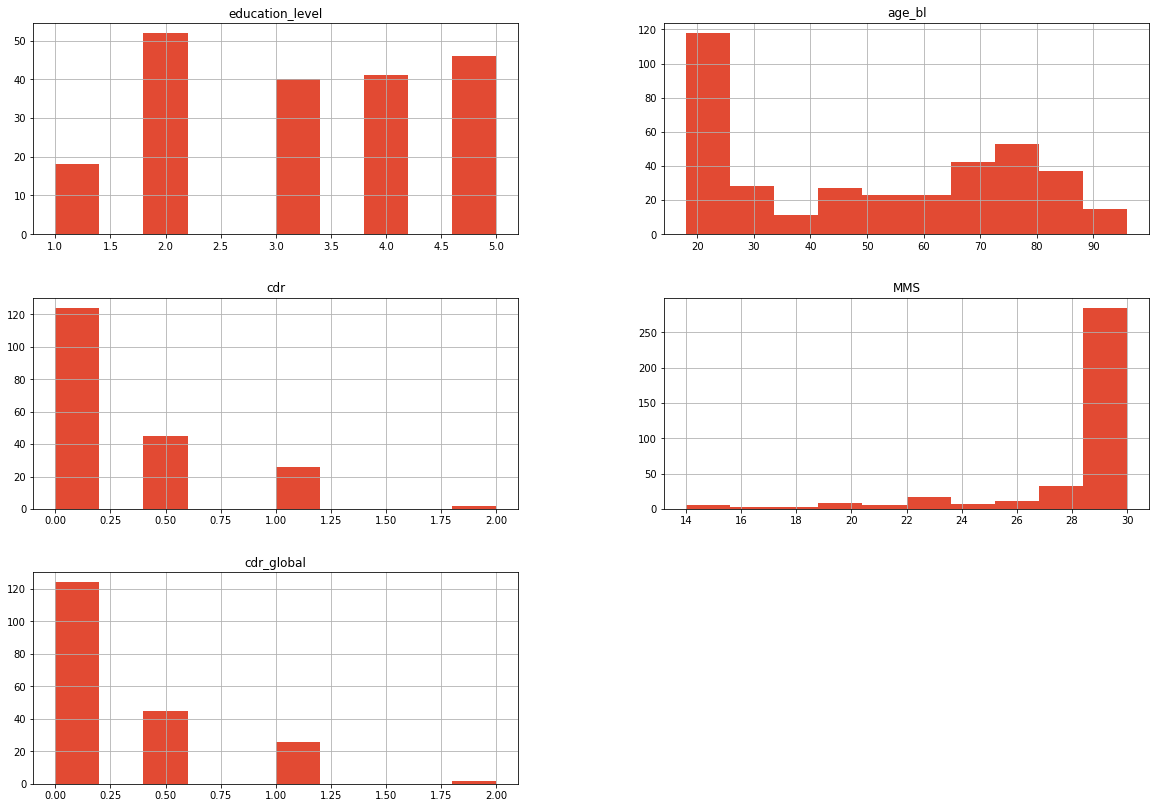

In [24]:
# Load the complete dataset
OASIS_df = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/OASIS_BIDS.tsv', sep='\t')
# Show first items of the table
print(OASIS_df.head())
# First visual inspection
_ = OASIS_df.hist(figsize=(20, 14), color="#e24a33")

From these graphics, it's possible to have an overview of the distribution of
the data, for the numerical values. For example, the educational level is
well distributed among the participants of the study. Also, most of the
subjects are young (around 20 years old) and healthy (MMS score equals 30 and null CDR score).

The next cell will create (and run) a function (`characteristics_table`) that
highlights the main features of the population in the dataset. We will use it
later.

In [25]:
# Study the characteristics of the AD & CN populations (age, sex, MMS, cdr_global)
def characteristics_table(df, merged_df):
    """Creates a DataFrame that summarizes the characteristics of the DataFrame df"""
    diagnoses = np.unique(df.diagnosis.values)
    population_df = pd.DataFrame(index=diagnoses,
                                columns=['N', 'age', '%sexF', 'education',
                                         'MMS', 'CDR=0', 'CDR=0.5', 'CDR=1', 'CDR=2'])
    merged_df = merged_df.set_index(['participant_id', 'session_id'], drop=True)
    df = df.set_index(['participant_id', 'session_id'], drop=True)
    sub_merged_df = merged_df.loc[df.index]

    for diagnosis in population_df.index.values:
        diagnosis_df = sub_merged_df[df.diagnosis == diagnosis]
        population_df.loc[diagnosis, 'N'] = len(diagnosis_df)
        # Age
        mean_age = np.mean(diagnosis_df.age_bl)
        std_age = np.std(diagnosis_df.age_bl)
        population_df.loc[diagnosis, 'age'] = '%.1f ± %.1f' % (mean_age, std_age)
        # Sex
        population_df.loc[diagnosis, '%sexF'] = round((len(diagnosis_df[diagnosis_df.sex == 'F']) / len(diagnosis_df)) * 100, 1)
        # Education level
        mean_education_level = np.nanmean(diagnosis_df.education_level)
        std_education_level = np.nanstd(diagnosis_df.education_level)
        population_df.loc[diagnosis, 'education'] = '%.1f ± %.1f' % (mean_education_level, std_education_level)
        # MMS
        mean_MMS = np.mean(diagnosis_df.MMS)
        std_MMS = np.std(diagnosis_df.MMS)
        population_df.loc[diagnosis, 'MMS'] = '%.1f ± %.1f' % (mean_MMS, std_MMS)
        # CDR
        for value in ['0', '0.5', '1', '2']:
          population_df.loc[diagnosis, 'CDR=%s' % value] = len(diagnosis_df[diagnosis_df.cdr_global == float(value)])

    return population_df

population_df = characteristics_table(OASIS_df, OASIS_df)
population_df

,N,age,%sexF,education,MMS,CDR=0,CDR=0.5,CDR=1,CDR=2
AD,73,77.5 ± 7.4,63.0,2.7 ± 1.3,22.7 ± 3.6,0,45,26,2
CN,304,44.0 ± 23.3,62.2,3.5 ± 1.2,29.7 ± 0.6,124,0,0,0


## Preprocessing

Theoretically, the main advantage of deep learning methods is to be able to
work without extensive data preprocessing. However, as we have only a few
images to train the network in this lab session, the preprocessing here is
very extensive. More specifically, the images encountered:

1. Non-linear registration.
2. Segmentation of grey matter.
3. Conversion to tensor format (.pt).


As mentioned above, to obtain the preprocessed images, we used some Clinica's
pipelines in order to: 

1. Convert the original dataset to BIDS format ([`clinica convert
oasis-2-bids`](http://www.clinica.run/doc/Converters/OASIS2BIDS/)).
2. Get the non-linear registration and segmentation of grey mater (pipeline
[`t1-volume`](http://www.clinica.run/doc/Pipelines/T1_Volume/)).
3. Obtain the preprocessed images in tensor format (pipeline
[`deeplearning-prepare-data`](https://aramislab.paris.inria.fr/clinica/docs/public/latest/Pipelines/DeepLearning_PrepareData/)).


The preprocessed images are store in the [CAPS
folder structure](http://www.clinica.run/doc/CAPS/Introduction/) and all have
the same size (121x145x121). You will find below a *class* called `MRIDataset`
which allows easy browsing in the database.

In [26]:
from torch.utils.data import Dataset, DataLoader, sampler
from os import path

class MRIDataset(Dataset):

    def __init__(self, img_dir, data_df, transform=None):
        """
        Args:
            img_dir (str): path to the CAPS directory containing preprocessed images
            data_df (DataFrame): metadata of the population.
                Columns include participant_id, session_id and diagnosis).
            transform (callable): list of transforms applied on-the-fly, chained with torchvision.transforms.Compose.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.data_df = data_df
        self.label_code = {"AD": 1, "CN": 0}

        self.size = self[0]['image'].shape

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):

        diagnosis = self.data_df.loc[idx, 'diagnosis']
        label = self.label_code[diagnosis]

        participant_id = self.data_df.loc[idx, 'participant_id']
        session_id = self.data_df.loc[idx, 'session_id']
        filename = 'subjects/' + participant_id + '/' + session_id + '/' + \
          'deeplearning_prepare_data/image_based/custom/' + \
          participant_id + '_' + session_id + \
          '_T1w_segm-graymatter_space-Ixi549Space_modulated-off_probability.pt'

        image = torch.load(path.join(self.img_dir, filename))

        if self.transform:
            image = self.transform(image)

        sample = {'image': image, 'label': label,
                  'participant_id': participant_id,
                  'session_id': session_id}
        return sample

    def train(self):
        self.transform.train()

    def eval(self):
        self.transform.eval()

To facilitate the training and avoid overfitting due to the limited amount of
data, the network won't use the full image but only a part of the image (size
30x40x30) centered on a specific neuroanatomical region: the hippocampus
(HC).
This structure is known to be linked to memory, and is atrophied in the
majority of cases of Alzheimer's disease patients.

To improve the training and reduce overfitting, a random shift was added to
the cropping function. This means that the bounding box around the
hippocampus may be shifted by a limited amount of voxels in each of the three
directions.

In [27]:
class CropLeftHC(object):
    """Crops the left hippocampus of a MRI non-linearly registered to MNI"""
    def __init__(self, random_shift=0):
        self.random_shift = random_shift
        self.train_mode = True
    def __call__(self, img):
        if self.train_mode:
            x = random.randint(-self.random_shift, self.random_shift)
            y = random.randint(-self.random_shift, self.random_shift)
            z = random.randint(-self.random_shift, self.random_shift)
        else:
            x, y, z = 0, 0, 0
        return img[:, 25 + x:55 + x,
                   50 + y:90 + y,
                   27 + z:57 + z].clone()

    def train(self):
        self.train_mode = True

    def eval(self):
        self.train_mode = False

class CropRightHC(object):
    """Crops the right hippocampus of a MRI non-linearly registered to MNI"""
    def __init__(self, random_shift=0):
        self.random_shift = random_shift
        self.train_mode = True
    def __call__(self, img):
        if self.train_mode:
            x = random.randint(-self.random_shift, self.random_shift)
            y = random.randint(-self.random_shift, self.random_shift)
            z = random.randint(-self.random_shift, self.random_shift)
        else:
            x, y, z = 0, 0, 0
        return img[:, 65 + x:95 + x,
                   50 + y:90 + y,
                   27 + z:57 + z].clone()

    def train(self):
        self.train_mode = True

    def eval(self):
        self.train_mode = False

## Visualization

Here we visualize the raw, preprocessed and cropped data.

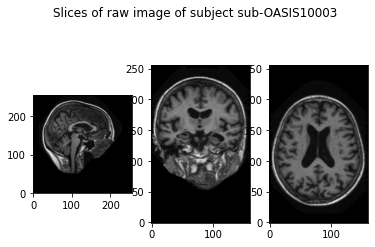

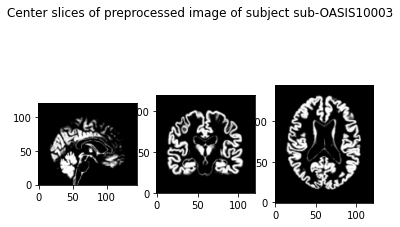

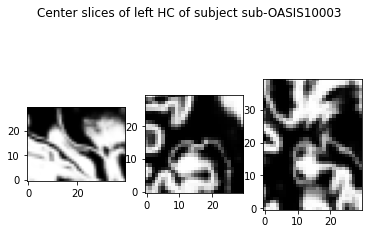

In [28]:
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage import rotate

subject = 'sub-OASIS10003'
preprocessed_pt = torch.load(f'OASIS-1_dataset/CAPS/subjects/{subject}/ses-M00/' +
                    f'deeplearning_prepare_data/image_based/custom/{subject}_ses-M00_' +
                    'T1w_segm-graymatter_space-Ixi549Space_modulated-off_' +
                    'probability.pt')
raw_nii = nib.load(f'OASIS-1_dataset/raw/{subject}_ses-M00_T1w.nii.gz')

raw_np = raw_nii.get_fdata()

def show_slices(slices):
    """ Function to display a row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

slice_0 = raw_np[:, :, 78]
slice_1 = raw_np[122, :, :]
slice_2 = raw_np[:, 173, :]
show_slices([slice_0, rotate(slice_1, 90), rotate(slice_2, 90)])
plt.suptitle(f'Slices of raw image of subject {subject}')
plt.show()

slice_0 = preprocessed_pt[0, 60, :, :]
slice_1 = preprocessed_pt[0, :, 72, :]
slice_2 = preprocessed_pt[0, :, :, 60]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle(f'Center slices of preprocessed image of subject {subject}')
plt.show()

leftHC_pt = CropLeftHC()(preprocessed_pt)
slice_0 = leftHC_pt[0, 15, :, :]
slice_1 = leftHC_pt[0, :, 20, :]
slice_2 = leftHC_pt[0, :, :, 15]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle(f'Center slices of left HC of subject {subject}')
plt.show()

# 1. Cross-validation

In order to choose hyperparameters the set of images is divided into a
training set (80%) and a validation set (20%). The data split was performed
in order to ensure a similar distribution of diagnosis, age and sex between
the subjects of the training set and the subjects of the validation set.
Moreover the MMS distribution of each class is preserved.

In [29]:
train_df = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/train.tsv', sep='\t')
valid_df = pd.read_csv('OASIS-1_dataset/tsv_files/lab_1/validation.tsv', sep='\t')

train_population_df = characteristics_table(train_df, OASIS_df)
valid_population_df = characteristics_table(valid_df, OASIS_df)

print(f"Train dataset:\n {train_population_df}\n")
print(f"Validation dataset:\n {valid_population_df}")

Train dataset:
       N          age %sexF  education         MMS CDR=0 CDR=0.5 CDR=1 CDR=2
AD   58   77.4 ± 7.5  69.0  2.8 ± 1.4  22.6 ± 3.6     0      37    19     2
CN  242  43.4 ± 23.5  62.0  3.6 ± 1.2  29.8 ± 0.5    97       0     0     0

Validation dataset:
      N          age %sexF  education         MMS CDR=0 CDR=0.5 CDR=1 CDR=2
AD  15   78.2 ± 6.6  40.0  2.5 ± 1.0  22.9 ± 3.6     0       8     7     0
CN  62  46.3 ± 22.6  62.9  3.4 ± 1.3  29.6 ± 0.7    27       0     0     0


# 2. Model
We propose here to design a convolutional neural network that takes for input
a patch centered on the left hippocampus of size 30x40x30. The architecture
of the network was found using a Random Search on architecture + optimization
hyperparameters.


## Reminder on CNN layers

In a CNN everything is called a layer though the operations layers perform
are very different. You will find below a summary of the different operations
that may be performed in a CNN.


### Feature maps

The outputs of the layers in a convolutional network are called feature maps.
Their size is written with the format: 

> `n_channels @ dim1 x dim2 x dim3`

For a 3D CNN the dimension of the feature maps is actually 5D as the first
dimension is the batch size. This dimension is added by the `DataLoader` of
Pytorch which stacks the 4D tensors computed by a `Dataset`.

In [30]:
img_dir = path.join('OASIS-1_dataset', 'CAPS')
batch_size=4

example_dataset = MRIDataset(img_dir, OASIS_df, transform=CropLeftHC())
example_dataloader = DataLoader(example_dataset, batch_size=batch_size, drop_last=True)
for data in example_dataloader:
    pass

print(f"Shape of Dataset output:\n {example_dataset[0]['image'].shape}\n")

print(f"Shape of DataLoader output:\n {data['image'].shape}")

Shape of Dataset output:
 torch.Size([1, 30, 40, 30])

Shape of DataLoader output:
 torch.Size([4, 1, 30, 40, 30])


### Convolutions (`nn.Conv3d`)

The main arguments of this layer are the input channels, the output channels
(number of filters trained) and the size of the filter (or kernel). If an
integer `k` is given the kernel will be a cube of size `k`. It is possible to
construct rectangular kernels by entering a tuple (but this is very rare).

You will find below an illustration of how a single filter produces its
output feature map by parsing the one feature map. The size of the output
feature map produced depends of the convolution parameters and can be
computed with the following formula:

> $O_i = \frac{I_i-k+2P}{S} + 1$

*   $O_i$ the size of the output along the ith dimension
*   $I_i$ the size of the input along the ith dimension
*   $k$ the size of the kernel
*   $P$ the padding value
*   $S$ the stride value

In the following example $\frac{5-3+2*0}{1}+1 = 3$

<img src="https://drive.google.com/uc?id=166EuqiwIZkKPMOlVzA-v5WemJE2tDCES" style="height: 200px;">

To be able to parse all the feature maps of the input, one filter is actually
a 4D tensor of size `(input_channels, k, k, k)`. The ensemble of all the
filters included in one convolutional layer is then a 5D tensor stacking all
the filters of size `(output_channels, input_channels, k, k, k)`.

Each filter is also associated to one bias value that is a scalar added to
all the feature maps it produces. Then the bias is a 1D vector of size
`output_channels`.

In [33]:
from torch import nn

conv_layer = nn.Conv3d(8, 16, 3)
print('Weights shape\n', conv_layer.weight.shape)
print()
print('Bias shape\n', conv_layer.bias.shape)

Weights shape
 torch.Size([16, 8, 3, 3, 3])

Bias shape
 torch.Size([16])


### Batch Normalization (`nn.BatchNorm3d`)

Learns to normalize feature maps according to [(Ioffe & Szegedy,
2015)](https://arxiv.org/abs/1502.03167). The following formula is applied on
each feature map  $FM_i$:

> $FM^{normalized}_i = \frac{FM_i - mean(FM_i)}{\sqrt{var(FM_i) + \epsilon}} * \gamma_i + \beta_i$

*   $\epsilon$ is a hyperparameter of the layer (default=1e-05)
*   $\gamma_i$ is the value of the scale for the ith channel (learnable parameter)
*   $\beta_i$ is the value of the shift for the ith channel (learnable parameter)

This layer does not have the same behaviour during training and evaluation,
this is why it is needed to put the model in evaluation mode in the test
function with the command `.eval()`

In [34]:
batch_layer = nn.BatchNorm3d(16)
print('Gamma value\n', batch_layer.state_dict()['weight'].shape)
print()
print('Beta value\n', batch_layer.state_dict()['bias'].shape)

Gamma value
 torch.Size([16])

Beta value
 torch.Size([16])


### Activation function (`nn.LeakyReLU`)

In order to introduce non-linearity in the model, an activation function is
introduced after the convolutions. It is applied on all intensities
independently.

The graph of the Leaky ReLU is displayed below, $\alpha$ being a
hyperparameter of the layer (default=0.01):

![Leaky ReLU graph](https://sefiks.com/wp-content/uploads/2018/02/prelu.jpg?w=600)

### Pooling function (`PadMaxPool3d`)

The structure of the pooling layer is very similar to the convolutional
layer: a kernel is passing through the input with a defined size and stride.
However there is no learnable parameters in this layer, the kernel outputing
the maximum value of the part of the feature map it covers.

Here is an example in 2D of the standard layer of pytorch `nn.MaxPool2d`:

![nn.MaxPool2d behaviour](https://drive.google.com/uc?id=1qh9M9r9mfpZeSD1VjOGQAl8zWqBLmcKz)

We can observe that the last column may not be used depending on the size of
the kernel/input and stride value.

This is why the custom module `PadMaxPool` was defined to pad the input in
order to exploit information from the whole feature map.

In [35]:
class PadMaxPool3d(nn.Module):
    """A MaxPooling module which deals with odd sizes with padding"""
    def __init__(self, kernel_size, stride, return_indices=False, return_pad=False):
        super(PadMaxPool3d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.pool = nn.MaxPool3d(kernel_size, stride, return_indices=return_indices)
        self.pad = nn.ConstantPad3d(padding=0, value=0)
        self.return_indices = return_indices
        self.return_pad = return_pad

    def set_new_return(self, return_indices=True, return_pad=True):
        self.return_indices = return_indices
        self.return_pad = return_pad
        self.pool.return_indices = return_indices

    def forward(self, f_maps):
        coords = [self.stride - f_maps.size(i + 2) % self.stride for i in range(3)]
        for i, coord in enumerate(coords):
            if coord == self.stride:
                coords[i] = 0

        self.pad.padding = (coords[2], 0, coords[1], 0, coords[0], 0)

        if self.return_indices:
            output, indices = self.pool(self.pad(f_maps))

            if self.return_pad:
                return output, indices, (coords[2], 0, coords[1], 0, coords[0], 0)
            else:
                return output, indices

        else:
            output = self.pool(self.pad(f_maps))

            if self.return_pad:
                return output, (coords[2], 0, coords[1], 0, coords[0], 0)
            else:
                return output

Here is an illustration of `PadMaxPool` behaviour. If the number of columns is odd, a column is added to avoid
losing data:

<a href="PadMaxPool behaviour"><img src="https://drive.google.com/uc?id=14R_LCTiV0N6ZXm-3wQCj_Gtc1LsXdQq_" style="height: 200px;"></a>

Similarly, the formula to find the size of the output feature map is:

> $O_i = ceil(\frac{I_i-k+2P}{S}) + 1$

### Dropout (`nn.Dropout`) 
The aim of a dropout layer is to replace a fixed proportion of the input
values by 0 during training only.

This layer does not have the same behaviour during training and evaluation,
this is why it is needed to put the model in evaluation mode in the test
function with the command `.eval()`

In [37]:
dropout = nn.Dropout(0.5)
input_tensor = torch.rand(10)
output_tensor = dropout(input_tensor)
print("Input \n", input_tensor)
print()
print("Output \n", output_tensor)

Input 
 tensor([0.0299, 0.0857, 0.3442, 0.1453, 0.1206, 0.7062, 0.7680, 0.2983, 0.8475,
        0.9779])

Output 
 tensor([0.0000, 0.0000, 0.6883, 0.2906, 0.0000, 0.0000, 1.5361, 0.5967, 0.0000,
        1.9558])


### Fully-Connected Layers (`nn.Linear`)

The fully connected layers take as input 2D vectors of size `(batch_size,
N)`. They have two mandatory arguments, the number of values per batch of the
input and the number of values per batch of the output.

Each output neuron in a FC layer is a linear combination of the inputs + a
bias.

In [39]:
fc = nn.Linear(16, 2)
print("Weights shape \n", fc.weight.shape)
print()
print("Bias shape \n", fc.bias.shape)

Weights shape 
 torch.Size([2, 16])

Bias shape 
 torch.Size([2])


## Network design
Construct here the network corresponding to the scheme and the following
description:

![Scheme of the network](https://drive.google.com/uc?id=1Qi-ictqudBX4ToBXzqT5w57RHrkn3MPR)

The network includes 3 convolutional blocks composed by a convolutional layer
(kernel size = 3, padding = 1, stride = 1), a batch normalization, a
LeakyReLU activation and a MaxPooling layer. The 3 successive layers include
respectively 8, 16 and 32 filters.

Then, the feature maps array is flattened in a 1D array to enter a
fully-connected layer. Between the convolutional and the fully-connected
layers, a dropout layer with a dropout rate of 0.5 is inserted. 

In [42]:
# To complete
class CustomNetwork(nn.Module):

    def __init__(self):
        super(CustomNetwork, self).__init__()
        self.convolutions = nn.Sequential(
            nn.Conv3d(1, 8, 3, padding=1),
            # Size 8@30x40x30
            nn.BatchNorm3d(8),
            nn.LeakyReLU(),
            PadMaxPool3d(2, 2),
            # Size 8@15x20x15

            nn.Conv3d(8, 16, 3, padding=1),
            # Size 16@15x20x15
            nn.BatchNorm3d(16),
            nn.LeakyReLU(),
            PadMaxPool3d(2, 2),
            # Size 16@8x10x8)

            nn.Conv3d(16, 32, 3, padding=1),
            # Size 32@8x10x8
            nn.BatchNorm3d(32),
            nn.LeakyReLU(),
            PadMaxPool3d(2, 2),
            # Size 32@4x5x4

        )

        self.linear = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(32 * 4 * 5 * 4, 2)

        )

    def forward(self, x):
        x = self.convolutions(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

# 3. Train & Test

Complete the `train` method in order to iteratively update the weights of the
network.

Here the model leading to the lowest loss on the training set at the end of
an epoch is returned, however we could choose instead the model leading to
the highest balanced accuracy, or the one obtained at the last iteration.

In many studies of deep learning the validation set is used during training
to choose when the training should stop (early stopping) but also to retrieve
the best model (model selection).

As we don't have any test set to evaluate the final model selected in an
unbiased way, we chose not to use the validation set in training in order to
limit the bias of the validation set. However you can choose to implement an
early stopping and / or model selection based on the validation set, but
remember that even if your results on the validation set are better, that
doesn't mean that this would be the case on an independent test set.

In [43]:
def train(model, train_loader, criterion, optimizer, n_epochs):
    """
    Method used to train a CNN

    Args:
        model: (nn.Module) the neural network
        train_loader: (DataLoader) a DataLoader wrapping a MRIDataset
        criterion: (nn.Module) a method to compute the loss of a mini-batch of images
        optimizer: (torch.optim) an optimization algorithm
        n_epochs: (int) number of epochs performed during training

    Returns:
        best_model: (nn.Module) the trained neural network
    """
    best_model = deepcopy(model)
    train_best_loss = np.inf

    for epoch in range(n_epochs):
        model.train()
        train_loader.dataset.train()
        for i, data in enumerate(train_loader, 0):
            # Retrieve mini-batch and put data on GPU with .cuda()
            images, labels = data['image'].cuda(), data['label'].cuda()
            # Forward pass
            outputs = model(images)
            # Loss computation
            loss = criterion(outputs, labels)
            # Back-propagation (gradients computation)
            loss.backward()
            # Parameters update
            optimizer.step()
            # Erase previous gradients
            optimizer.zero_grad()

        _, train_metrics = test(model, train_loader, criterion)

        print(
            f"Epoch {epoch}: loss = {train_metrics['mean_loss']:.4f}, "
            f"balanced accuracy = {train_metrics['balanced_accuracy']:.4f}"
            )

        if train_metrics['mean_loss'] < train_best_loss:
            best_model = deepcopy(model)
            train_best_loss = train_metrics['mean_loss']

    return best_model

def test(model, data_loader, criterion):
    """
    Method used to test a CNN

    Args:
        model: (nn.Module) the neural network
        data_loader: (DataLoader) a DataLoader wrapping a MRIDataset
        criterion: (nn.Module) a method to compute the loss of a mini-batch of images

    Returns:
        results_df: (DataFrame) the label predicted for every subject
        results_metrics: (dict) a set of metrics
    """
    model.eval()
    data_loader.dataset.eval()
    columns = ["participant_id", "proba0", "proba1",
               "true_label", "predicted_label"]
    results_df = pd.DataFrame(columns=columns)
    total_loss = 0

    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            images, labels = data['image'].cuda(), data['label'].cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            probs = nn.Softmax(dim=1)(outputs)
            _, predicted = torch.max(outputs.data, 1)

            for idx, sub in enumerate(data['participant_id']):
                row = [sub,
                       probs[idx, 0].item(), probs[idx, 1].item(),
                       labels[idx].item(), predicted[idx].item()]
                row_df = pd.DataFrame([row], columns=columns)
                results_df = pd.concat([results_df, row_df])

    results_metrics = compute_metrics(results_df.true_label.values, results_df.predicted_label.values)
    results_df.reset_index(inplace=True, drop=True)
    results_metrics['mean_loss'] = total_loss / len(data_loader.dataset)

    return results_df, results_metrics


def compute_metrics(ground_truth, prediction):
    """Computes the accuracy, sensitivity, specificity and balanced accuracy"""
    tp = np.sum((prediction == 1) & (ground_truth == 1))
    tn = np.sum((prediction == 0) & (ground_truth == 0))
    fp = np.sum((prediction == 1) & (ground_truth == 0))
    fn = np.sum((prediction == 0) & (ground_truth == 1))

    metrics_dict = dict()
    metrics_dict['accuracy'] = (tp + tn) / (tp + tn + fp + fn)

    # Sensitivity
    if tp + fn != 0:
        metrics_dict['sensitivity'] = tp / (tp + fn)
    else:
        metrics_dict['sensitivity'] = 0.0

    # Specificity
    if fp + tn != 0:
        metrics_dict['specificity'] = tn / (fp + tn)
    else:
        metrics_dict['specificity'] = 0.0

    metrics_dict['balanced_accuracy'] = (metrics_dict['sensitivity'] + metrics_dict['specificity']) / 2

    return metrics_dict

## Train Classification with Left HC

Here we will train a first network that will learn to perform the binary
classification AD vs CN on a cropped image around the left hippocampus.

All hyperparameters may have an influence, but one of the most influent is
the learning rate that can lead to a poor convergence if it is too high or
low. Try different learning rate between $10 ^{-5}$ and $10 ^{-3}$ and
observe the differences of loss variations during training.

To increase the training speed you can also increase the batch size. But be
careful, if the batch size becomes a non-negligible amount of the training
set it may have a negative impact on loss convergence [(Keskar et al,
2016)](https://arxiv.org/abs/1609.04836). 

Construction of dataset objects:

In [44]:
img_dir = path.join('OASIS-1_dataset', 'CAPS')
transform = CropLeftHC(2)

train_datasetLeftHC = MRIDataset(img_dir, train_df, transform=transform)
valid_datasetLeftHC = MRIDataset(img_dir, valid_df, transform=transform)

# Try different learning rates
learning_rate = 10**-4
n_epochs = 30
batch_size = 4

# Put the network on GPU
modelLeftHC = CustomNetwork().cuda()
train_loaderLeftHC = DataLoader(train_datasetLeftHC, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
# A high batch size improves test speed
valid_loaderLeftHC = DataLoader(valid_datasetLeftHC, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(modelLeftHC.parameters(), learning_rate)

best_modelLeftHC = train(modelLeftHC, train_loaderLeftHC, criterion, optimizer, n_epochs)

valid_resultsLeftHC_df, valid_metricsLeftHC = test(best_modelLeftHC, valid_loaderLeftHC, criterion)
train_resultsLeftHC_df, train_metricsLeftHC = test(best_modelLeftHC, train_loaderLeftHC, criterion)
print(valid_metricsLeftHC)
print(train_metricsLeftHC)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: loss = 0.3980, balanced accuracy = 0.5000


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1: loss = 0.2753, balanced accuracy = 0.7093


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 2: loss = 0.2524, balanced accuracy = 0.7269


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 3: loss = 0.2391, balanced accuracy = 0.7949


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 4: loss = 0.2432, balanced accuracy = 0.8511


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 5: loss = 0.2498, balanced accuracy = 0.8515


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 6: loss = 0.2319, balanced accuracy = 0.8207


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 7: loss = 0.2259, balanced accuracy = 0.7642


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 8: loss = 0.2429, balanced accuracy = 0.7310


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 9: loss = 0.2183, balanced accuracy = 0.8056


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 10: loss = 0.2154, balanced accuracy = 0.7966


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 11: loss = 0.2295, balanced accuracy = 0.7528


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 12: loss = 0.2317, balanced accuracy = 0.7462


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 13: loss = 0.2090, balanced accuracy = 0.8249


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 14: loss = 0.2053, balanced accuracy = 0.8204


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 15: loss = 0.2040, balanced accuracy = 0.8314


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 16: loss = 0.2278, balanced accuracy = 0.7569


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 17: loss = 0.2017, balanced accuracy = 0.8314


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 18: loss = 0.2047, balanced accuracy = 0.8683


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 19: loss = 0.1982, balanced accuracy = 0.7831


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 20: loss = 0.2383, balanced accuracy = 0.9294


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 21: loss = 0.1840, balanced accuracy = 0.8311


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 22: loss = 0.1818, balanced accuracy = 0.8311


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 23: loss = 0.1902, balanced accuracy = 0.7828


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 24: loss = 0.1906, balanced accuracy = 0.7828


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 25: loss = 0.1757, balanced accuracy = 0.8352


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 26: loss = 0.1847, balanced accuracy = 0.8921


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 27: loss = 0.1841, balanced accuracy = 0.9094


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 28: loss = 0.1904, balanced accuracy = 0.7848


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 29: loss = 0.3481, balanced accuracy = 0.9091


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'accuracy': 0.8701298701298701, 'sensitivity': 0.6, 'specificity': 0.9354838709677419, 'balanced_accuracy': 0.7677419354838709, 'mean_loss': 0.3049909472465515}
{'accuracy': 0.9033333333333333, 'sensitivity': 0.7241379310344828, 'specificity': 0.9462809917355371, 'balanced_accuracy': 0.83520946138501, 'mean_loss': 0.17572754374394814}


If you obtained about 0.85 or more of balanced accuracy, there may be
something wrong... Are you absolutely sure that your dataset is unbiased?

If you didn't remove the youngest subjects of OASIS, your dataset is biased
as the AD and CN participants do not have the same age distribution.
In practice people who come to the hospital for a diagnosis of Alzheimer's
disease all have about the same age (50 - 90). No one has Alzheimer's disease
at 20 ! Then you should check that the performance of the network is still
good for the old population only.

Check the accuracy on old participants (age > 62 to match the minimum of AD age
distribution)

In [49]:
valid_resultsLeftHC_df = valid_resultsLeftHC_df.merge(OASIS_df, how='left', on='participant_id', sort=False)
valid_resultsLeftHC_old_df = valid_resultsLeftHC_df[(valid_resultsLeftHC_df.age_bl >= 62)]
compute_metrics(valid_resultsLeftHC_old_df.true_label, valid_resultsLeftHC_old_df.predicted_label)

<ipython-input-49-e255bf33fb18>:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'cdr_global_x', 'cdr_x', 'sex_x', 'laterality_x', 'session_id_x', 'diagnosis_x', 'diagnosis_bl_x', 'education_level_x', 'alternative_id_1_x', 'MMS_x', 'age_bl_x'} in the result is deprecated and will raise a MergeError in a future version.
  valid_resultsLeftHC_df = valid_resultsLeftHC_df.merge(OASIS_df, how='left', on='participant_id', sort=False)


AttributeError: ignored

In [ ]:
valid_resultsLeftHC_df = valid_resultsLeftHC_df.merge(OASIS_df, how='left', on='participant_id', sort=False)
valid_resultsLeftHC_old_df = valid_resultsLeftHC_df[(valid_resultsLeftHC_df.age_bl >= 55)]
compute_metrics(valid_resultsLeftHC_old_df.true_label, valid_resultsLeftHC_old_df.predicted_label)

{'accuracy': 0.71875,
 'sensitivity': 0.6,
 'specificity': 0.8235294117647058,
 'balanced_accuracy': 0.7117647058823529}

In [ ]:
valid_resultsLeftHC_df = valid_resultsLeftHC_df.merge(OASIS_df, how='left', on='participant_id', sort=False)
valid_resultsLeftHC_old_df = valid_resultsLeftHC_df[(valid_resultsLeftHC_df.age_bl >= 50)]
compute_metrics(valid_resultsLeftHC_old_df.true_label, valid_resultsLeftHC_old_df.predicted_label)

{'accuracy': 0.71875,
 'sensitivity': 0.6,
 'specificity': 0.8235294117647058,
 'balanced_accuracy': 0.7117647058823529}

In [48]:
valid_resultsLeftHC_df = valid_resultsLeftHC_df.merge(OASIS_df, how='left', on='participant_id', sort=False)
valid_resultsLeftHC_old_df = valid_resultsLeftHC_df[(valid_resultsLeftHC_df.age_bl >= 67)]
compute_metrics(valid_resultsLeftHC_old_df.true_label, valid_resultsLeftHC_old_df.predicted_label)

{'accuracy': 0.71875,
 'sensitivity': 0.6,
 'specificity': 0.8235294117647058,
 'balanced_accuracy': 0.7117647058823529}

If the accuracy on old participants is very different from the one you obtained before,
this could mean that your network is inefficient on the target population (persons older than 60).
You have to think again about your framework and eventually retrain your network...

## Train Classification with Right HC

Another network can be trained on a cropped image around the right HC
network. The same hyperparameters as before may be reused.

Construction of dataset objects

In [46]:
transform = CropRightHC(2)

train_datasetRightHC = MRIDataset(img_dir, train_df, transform=transform)
valid_datasetRightHC = MRIDataset(img_dir, valid_df, transform=transform)

learning_rate = 10**-4
n_epochs = 30
batch_size = 4

# Put the network on GPU
modelRightHC = CustomNetwork().cuda()
train_loaderRightHC = DataLoader(train_datasetRightHC, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_loaderRightHC = DataLoader(valid_datasetRightHC, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(modelRightHC.parameters(), learning_rate)

best_modelRightHC = train(modelRightHC, train_loaderRightHC, criterion, optimizer, n_epochs)

valid_resultsRightHC_df, valid_metricsRightHC = test(best_modelRightHC, valid_loaderRightHC, criterion)
train_resultsRightHC_df, train_metricsRightHC = test(best_modelRightHC, train_loaderRightHC, criterion)
print(valid_metricsRightHC)
print(train_metricsRightHC)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: loss = 0.3450, balanced accuracy = 0.5131


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1: loss = 0.3198, balanced accuracy = 0.5217


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 2: loss = 0.3007, balanced accuracy = 0.6190


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 3: loss = 0.2450, balanced accuracy = 0.7728


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 4: loss = 0.2624, balanced accuracy = 0.8473


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 5: loss = 0.2525, balanced accuracy = 0.7400


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 6: loss = 0.2333, balanced accuracy = 0.7859


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 7: loss = 0.2471, balanced accuracy = 0.7552


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 8: loss = 0.4240, balanced accuracy = 0.9070


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 9: loss = 0.2855, balanced accuracy = 0.8932


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 10: loss = 0.2224, balanced accuracy = 0.7945


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 11: loss = 0.2210, balanced accuracy = 0.7900


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 12: loss = 0.2977, balanced accuracy = 0.9104


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 13: loss = 0.2352, balanced accuracy = 0.7380


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 14: loss = 0.2390, balanced accuracy = 0.8946


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 15: loss = 0.2102, balanced accuracy = 0.7987


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 16: loss = 0.2476, balanced accuracy = 0.7269


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 17: loss = 0.2042, balanced accuracy = 0.8463


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 18: loss = 0.2171, balanced accuracy = 0.7421


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 19: loss = 0.2168, balanced accuracy = 0.7421


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 20: loss = 0.2007, balanced accuracy = 0.8004


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 21: loss = 0.2033, balanced accuracy = 0.8811


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 22: loss = 0.3256, balanced accuracy = 0.6338


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 23: loss = 0.1913, balanced accuracy = 0.8590


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 24: loss = 0.1919, balanced accuracy = 0.8114


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 25: loss = 0.1894, balanced accuracy = 0.8635


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 26: loss = 0.1886, balanced accuracy = 0.8180


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 27: loss = 0.2064, balanced accuracy = 0.9246


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 28: loss = 0.1875, balanced accuracy = 0.8938


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 29: loss = 0.1816, balanced accuracy = 0.8459


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'accuracy': 0.8961038961038961, 'sensitivity': 0.6, 'specificity': 0.967741935483871, 'balanced_accuracy': 0.7838709677419355, 'mean_loss': 0.2502419404782258}
{'accuracy': 0.91, 'sensitivity': 0.7413793103448276, 'specificity': 0.9504132231404959, 'balanced_accuracy': 0.8458962667426617, 'mean_loss': 0.1816381277035301}


## Soft voting
To increase the accuracy of our system the results of the two networks can be
combined. Here we can give both hippocampi the same weight.

In [50]:
def softvoting(leftHC_df, rightHC_df):
    df1 = leftHC_df.set_index('participant_id', drop=True)
    df2 = rightHC_df.set_index('participant_id', drop=True)
    results_df = pd.DataFrame(index=df1.index.values,
                              columns=['true_label', 'predicted_label',
                                       'proba0', 'proba1'])
    results_df.true_label = df1.true_label
    # Compute predicted label and probabilities
    results_df.proba1 = 0.5 * df1.proba1 + 0.5 * df2.proba1
    results_df.proba0 = 0.5 * df1.proba0 + 0.5 * df2.proba0
    results_df.predicted_label = (0.5 * df1.proba1 + 0.5 * df2.proba1 > 0.5).astype(int)

    return results_df

valid_results = softvoting(valid_resultsLeftHC_df, valid_resultsRightHC_df)
valid_metrics = compute_metrics(valid_results.true_label, valid_results.predicted_label)
print(valid_metrics)

{'accuracy': 0.9090909090909091, 'sensitivity': 0.6666666666666666, 'specificity': 0.967741935483871, 'balanced_accuracy': 0.8172043010752688}


Keep in mind that the validation set was used to set the hyperparameters
(learning rate, architecture), then validation metrics are biased. To have
unbiased results the entire framework should be evaluated on an independent
 set (test set).

# 4. Clustering on AD & CN populations

The classification results above were obtained in a supervised way:
neurologists examine the participants of OASIS and gave a diagnosis depending
on their clinical symptoms.

However, this label is often inaccurate (Beach et al, 2012).
Then an unsupervised framework can be interesting to check what can be found
in data without being biased by a noisy label.

## Model

A convenient architecture to extract features from an image with deep
learning is the autoencoder (AE). This architecture is made of two parts:
- the **encoder** which learns to compress the image in a smaller vector, the
**code**. *It is composed of the same kind of operations than the
convolutional part of the CNN seen before.*
- the **decoder** which learns to reconstruct the original image from the
code learnt by the encoder. *It is composed of the transposed version of the
operations used in the encoder.*

You will find below `CropMaxUnpool3d` the transposed version of
`PadMaxPool3d`.

In [51]:
class CropMaxUnpool3d(nn.Module):
    def __init__(self, kernel_size, stride):
        super(CropMaxUnpool3d, self).__init__()
        self.unpool = nn.MaxUnpool3d(kernel_size, stride)

    def forward(self, f_maps, indices, padding=None):
        output = self.unpool(f_maps, indices)
        if padding is not None:
            x1 = padding[4]
            y1 = padding[2]
            z1 = padding[0]
            output = output[:, :, x1::, y1::, z1::]

        return output

To facilitate the reconstruction process, the pooling layers in the encoder
return the position of the values that were the maximum. Hence the unpooling
layer can replace the maximum values at the right place in the 2x2x2 sub-cube
of the feature map. They also indicate if some zero padding was applied to
the feature map so that the unpooling layer can correctly crop their output
feature map.  

In [52]:
class AutoEncoder(nn.Module):

    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Initial size (30, 40, 30)

        self.encoder = nn.Sequential(
            nn.Conv3d(1, 8, 3, padding=1),
            nn.BatchNorm3d(8),
            nn.LeakyReLU(),
            PadMaxPool3d(2, 2, return_indices=True, return_pad=True),
            # Size (15, 20, 15)

            nn.Conv3d(8, 16, 3, padding=1),
            nn.BatchNorm3d(16),
            nn.LeakyReLU(),
            PadMaxPool3d(2, 2, return_indices=True, return_pad=True),
            # Size (8, 10, 8)

            nn.Conv3d(16, 32, 3, padding=1),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(),
            PadMaxPool3d(2, 2, return_indices=True, return_pad=True),
            # Size (4, 5, 4)

            nn.Conv3d(32, 1, 1),
            # Size (4, 5, 4)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(1, 32, 1),
            # Size (4, 5, 4)

            CropMaxUnpool3d(2, 2),
            nn.ConvTranspose3d(32, 16, 3, padding=1),
            nn.BatchNorm3d(16),
            nn.LeakyReLU(),
            # Size (8, 10, 8)

            CropMaxUnpool3d(2, 2),
            nn.ConvTranspose3d(16, 8, 3, padding=1),
            nn.BatchNorm3d(8),
            nn.LeakyReLU(),
            # Size (15, 20, 15)

            CropMaxUnpool3d(2, 2),
            nn.ConvTranspose3d(8, 1, 3, padding=1),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
            # Size (30, 40, 30)
        )

    def forward(self, x):
        indices_list = []
        pad_list = []
        for layer in self.encoder:
            if isinstance(layer, PadMaxPool3d):
                x, indices, pad = layer(x)
                indices_list.append(indices)
                pad_list.append(pad)
            else:
                x = layer(x)

        code = x.view(x.size(0), -1)
        for layer in self.decoder:
            if isinstance(layer, CropMaxUnpool3d):
                x = layer(x, indices_list.pop(), pad_list.pop())
            else:
                x = layer(x)

        return code, x

## Train Autoencoder

The training function of the autoencoder is very similar to the training
function of the CNN. The main difference is that the loss is not computed by
comparing the output with the diagnosis values using the cross-entropy loss,
but with the original image using for example the Mean Squared Error (MSE)
loss.

In [53]:
def trainAE(model, train_loader, criterion, optimizer, n_epochs):
    """
    Method used to train an AutoEncoder

    Args:
        model: (nn.Module) the neural network
        train_loader: (DataLoader) a DataLoader wrapping a MRIDataset
        criterion: (nn.Module) a method to compute the loss of a mini-batch of images
        optimizer: (torch.optim) an optimization algorithm
        n_epochs: (int) number of epochs performed during training

    Returns:
        best_model: (nn.Module) the trained neural network.
    """
    best_model = deepcopy(model)
    train_best_loss = np.inf

    for epoch in range(n_epochs):
        model.train()
        train_loader.dataset.train()
        for i, data in enumerate(train_loader, 0):
            # ToDo
            # Complete the training function in a similar way
            # than for the CNN classification training.
            # Retrieve mini-batch
            images, labels = data['image'].cuda(), data['label'].cuda()
            # Forward pass + loss computation
            _, outputs = model((images))
            loss = criterion(outputs, images)
            # Back-propagation
            loss.backward()
            # Parameters update
            optimizer.step()
            # Erase previous gradients
            optimizer.zero_grad()

        mean_loss = testAE(model, train_loader, criterion)

        print(f'Epoch {epoch}: loss = {mean_loss:.6f}')

        if mean_loss < train_best_loss:
            best_model = deepcopy(model)
            train_best_loss = mean_loss

    return best_model


def testAE(model, data_loader, criterion):
    """
    Method used to test an AutoEncoder

    Args:
        model: (nn.Module) the neural network
        data_loader: (DataLoader) a DataLoader wrapping a MRIDataset
        criterion: (nn.Module) a method to compute the loss of a mini-batch of images

    Returns:
        results_df: (DataFrame) the label predicted for every subject
        results_metrics: (dict) a set of metrics
    """
    model.eval()
    data_loader.dataset.eval()
    total_loss = 0

    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            images, labels = data['image'].cuda(), data['label'].cuda()
            _, outputs = model((images))
            loss = criterion(outputs, images)
            total_loss += loss.item()

    return total_loss / len(data_loader.dataset) / np.product(data_loader.dataset.size)

In [54]:
learning_rate = 10**-3
n_epochs = 30
batch_size = 4

AELeftHC = AutoEncoder().cuda()
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(AELeftHC.parameters(), learning_rate)

best_AELeftHC = trainAE(AELeftHC, train_loaderLeftHC, criterion, optimizer, n_epochs)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0: loss = 0.081350
Epoch 1: loss = 0.059479
Epoch 2: loss = 0.048513
Epoch 3: loss = 0.042041
Epoch 4: loss = 0.036563
Epoch 5: loss = 0.034084
Epoch 6: loss = 0.030799
Epoch 7: loss = 0.028580
Epoch 8: loss = 0.026934
Epoch 9: loss = 0.025448
Epoch 10: loss = 0.024387
Epoch 11: loss = 0.023177
Epoch 12: loss = 0.022725
Epoch 13: loss = 0.021531
Epoch 14: loss = 0.021056
Epoch 15: loss = 0.020074
Epoch 16: loss = 0.019134
Epoch 17: loss = 0.018821
Epoch 18: loss = 0.017953
Epoch 19: loss = 0.017868
Epoch 20: loss = 0.017257
Epoch 21: loss = 0.016726
Epoch 22: loss = 0.016874
Epoch 23: loss = 0.016490
Epoch 24: loss = 0.016119
Epoch 25: loss = 0.015745
Epoch 26: loss = 0.015138
Epoch 27: loss = 0.014800
Epoch 28: loss = 0.015309
Epoch 29: loss = 0.014752


## Visualization

The simplest way to check if the AE training went well is to visualize the
output and compare it to the original image seen by the autoencoder.

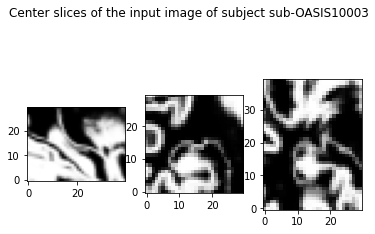

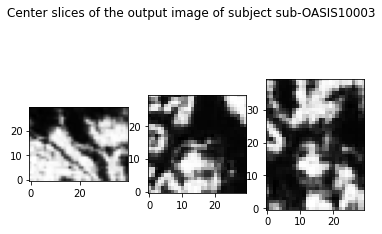

In [55]:
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage import rotate

subject = 'sub-OASIS10003'
preprocessed_pt = torch.load(f'OASIS-1_dataset/CAPS/subjects/{subject}/ses-M00/' +
                    'deeplearning_prepare_data/image_based/custom/' + subject +
                    '_ses-M00_'+
                    'T1w_segm-graymatter_space-Ixi549Space_modulated-off_' +
                    'probability.pt')
input_pt = CropLeftHC()(preprocessed_pt).unsqueeze(0).cuda()
_, output_pt = best_AELeftHC(input_pt)


slice_0 = input_pt[0, 0, 15, :, :].cpu()
slice_1 = input_pt[0, 0, :, 20, :].cpu()
slice_2 = input_pt[0, 0, :, :, 15].cpu()
show_slices([slice_0, slice_1, slice_2])
plt.suptitle(f'Center slices of the input image of subject {subject}')
plt.show()

slice_0 = output_pt[0, 0, 15, :, :].cpu().detach()
slice_1 = output_pt[0, 0, :, 20, :].cpu().detach()
slice_2 = output_pt[0, 0, :, :, 15].cpu().detach()
show_slices([slice_0, slice_1, slice_2])
plt.suptitle(f'Center slices of the output image of subject {subject}')
plt.show()

## Clustering

Now that the AE extracted the most salient parts of the image in a smaller
vector, the features obtained can be used for clustering.

Here we give an example with the Gaussian Mixture Model (GMM) of
scikit-learn. To use it we first need to concat the features and the labels
of all the subjects in two matrices *X* and *Y*. This is what is done in
`compute_dataset_features` method.

In [56]:
def compute_dataset_features(data_loader, model):

    concat_codes = torch.Tensor().cuda()
    concat_labels = torch.LongTensor()
    concat_names = []

    for data in data_loader:
      image = data['image'].cuda()
      labels = data['label']
      names = data['participant_id']

      code, _ = model(image)
      concat_codes = torch.cat([concat_codes, code.squeeze(1)], 0)
      concat_labels = torch.cat([concat_labels, labels])
      concat_names = concat_names + names

    concat_codes_np = concat_codes.cpu().detach().numpy()
    concat_labels_np = concat_labels.numpy()
    concat_names = np.array(concat_names)[:, np.newaxis]

    return concat_codes_np, concat_labels_np, concat_names

In [57]:
# train_codes, train_labels, names = compute_dataset_features(train_loaderBothHC, best_AEBothHC)
train_codes, train_labels, names = compute_dataset_features(train_loaderLeftHC, best_AELeftHC)

Then the model will fit the training codes and build two clusters. The labels
found in this unsupervised way can be compared to the true labels.

In [58]:
from sklearn import mixture
from sklearn.metrics import adjusted_rand_score

n_components = 2
model = mixture.GaussianMixture(n_components)
model.fit(train_codes)
train_predict = model.predict(train_codes)

metrics = compute_metrics(train_labels, train_predict)
ari = adjusted_rand_score(train_labels, train_predict)
print(f"Adjusted random index: {ari}")

Adjusted random index: 0.4001615413266804


The accuracy may not be very good, this could mean that the framework
clustered another characteristic that the one you tried to target.

What is actually expected is that the clustering differenciation is made on
the level of atrophy, which is mostly correlated to the age but also to the
disease stage (we can model it with the MMS score).

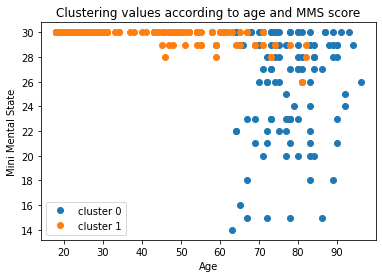

In [62]:
data_np = np.concatenate([names, train_codes,
                          train_labels[:, np.newaxis],
                          train_predict[:, np.newaxis]], axis=1)
columns = ['feature %i' % i for i in range(train_codes.shape[1])]
columns = ['participant_id'] + columns + ['true_label', 'predicted_label']
data_df = pd.DataFrame(data_np, columns=columns).set_index('participant_id')

merged_df = data_df.merge(OASIS_df.set_index('participant_id'), how='inner', on='participant_id')

plt.title('Clustering values according to age and MMS score')
for component in range(n_components):
    predict_df = merged_df[merged_df.predicted_label == str(component)]
    plt.plot(predict_df['age_bl'], predict_df['MMS'], 'o', label=f"cluster {component}")
plt.legend()
plt.xlabel('Age')
plt.ylabel('Mini Mental State')
plt.show()

You can try to improve this clustering by adding the codes obtained on the
right hippocampus, perform further dimension reduction or remove age effect
like in [(Moradi et al,
2015)](https://www.researchgate.net/publication/266374876_Machine_learning_framework_for_early_MRI-based_Alzheimer%27s_conversion_prediction_in_MCI_subjects)...